# Reproducing Figure 2A-D

Figure 2 presents results from sensitivity analysis of configuration 1.

**Note:** These are created from 10 replications currently for simplicity. At 10 replications, we would expect mean values to vary only slightly from further replication numbers. Hence, if felt similar at 10, have marked as succesfully reproduced without also testing at 100 replications.

## Parameters

In these figures, we vary:

* **Number of outpatients per day**:
    * 170 (same as config 4)
    * 85
    * 65
* **Average service time for outpatients** - mean (SD):
    * 0.87 (0.21) (same as config 1)
    * 2.5 (0.5)
    * 5 (1)

To calculate inter-arrival times from those numbers per day, based on article description and the provided patient counts and equivalent IAT, understand the method for calculation to be **round(60/(n/8.5))**,  where n is the number of arrivals per day. As such...

In [1]:
# Calculation of inter-arrival times
print(f'For 170 outpatients, use IAT (rounded to nearest int): {60/(170/8.5)}')
print(f'For 85 outpatients, use IAT (rounded to nearest int): {60/(85/8.5)}')
print(f'For 65 outpatients, use IAT (rounded to nearest int): {60/(65/8.5)}')

For 170 outpatients, use IAT (rounded to nearest int): 3.0
For 85 outpatients, use IAT (rounded to nearest int): 6.0
For 65 outpatients, use IAT (rounded to nearest int): 7.846153846153846


## Set up

In [2]:
# To run model
import PHC

# To import results and produce figures
from reproduction_helpers import process_results
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

# To speed up run time
from multiprocessing import Pool

'''
# Additional package to record runtime of this notebook
import time
start = time.time()
'''

'\n# Additional package to record runtime of this notebook\nimport time\nstart = time.time()\n'

In [3]:
# Paths to save image files to
output_folder = 'outputs'
fig2a_path = os.path.join(output_folder, 'fig2a.png')
fig2b_path = os.path.join(output_folder, 'fig2b.png')
fig2c_path = os.path.join(output_folder, 'fig2c.png')
fig2d_path = os.path.join(output_folder, 'fig2d.png')

## Run model

As this is a variation on configuration 1 (which is the default parameters in PHC.py), we just need to input the varying number of outpatients and service time.

In [4]:
# TODO: Run with 100 replications

# Varying number of outpatients
arr_dict = [
    {
        'OPD_iat': 3,
        'rep_file': 'arr170'
    },
    {
        'OPD_iat': 6,
        'rep_file': 'arr85',
    },
    {
        'OPD_iat': 8,
        'rep_file': 'arr65',
    }
]

# Varying service time
serv_dict = [
    {
        'mean': 0.87,
        'sd': 0.21,
        'consult_boundary_1': 0.5,  # From PHC.py
        'consult_boundary_2': 0.3,  # From PHC.py
        'rep_file': 'serv087'
    },
    {
        'mean': 2.5,
        'sd': 0.5,
        'consult_boundary_1': 1,  # Guess
        'consult_boundary_2': 1,  # Guess
        'rep_file': 'serv25'
    },
    {
        'mean': 5,
        'sd': 1,
        'consult_boundary_1': 2,  # From config 4
        'consult_boundary_2': 2,  # From config 4
        'rep_file': 'serv5'
    }
]

Create each combination for the reproduction

In [5]:
dict_list = []
for arr in arr_dict:
    for serv in serv_dict:
        # Combine the dictionaries
        comb = {**arr, **serv}
        # Replace the file name
        comb['rep_file'] = f'''f2_{arr['rep_file']}_{serv['rep_file']}.xls'''
        # Save to list
        dict_list.append(comb)

len(dict_list)

9

In [6]:
# Append 's_' to all items
for i, d in enumerate(dict_list):
    dict_list[i] = {f's_{k}': v for k, v in d.items()}

# Preview example
dict_list[0]

{'s_OPD_iat': 3,
 's_rep_file': 'f2_arr170_serv087.xls',
 's_mean': 0.87,
 's_sd': 0.21,
 's_consult_boundary_1': 0.5,
 's_consult_boundary_2': 0.3}

Run the model (with parallel processing to reduce run time)

In [7]:
'''
# Wrapper function to allow input of dictionary with pool
def wrapper(d):
    return PHC.main(**d)

# Create a process pool that uses all CPUs
with Pool() as pool:
    # Run PHC.main() using each of inputs from config
    pool.map(wrapper, dict_list)
'''

'\n# Wrapper function to allow input of dictionary with pool\ndef wrapper(d):\n    return PHC.main(**d)\n\n# Create a process pool that uses all CPUs\nwith Pool() as pool:\n    # Run PHC.main() using each of inputs from config\n    pool.map(wrapper, dict_list)\n'

## Create Figure 2A

In [8]:
# Import and process results
data_full = process_results([
    'f2_arr170_serv087', 'f2_arr85_serv087', 'f2_arr65_serv087',
    'f2_arr170_serv25', 'f2_arr85_serv25', 'f2_arr65_serv25',
    'f2_arr170_serv5', 'f2_arr85_serv5', 'f2_arr65_serv5'])

# Filter to doctor utilisation
data_2a = data_full.loc['doc occ']
data_2a

f2_arr170_serv087    0.311611
f2_arr85_serv087     0.224704
f2_arr65_serv087     0.202088
f2_arr170_serv25     0.639213
f2_arr85_serv25      0.390103
f2_arr65_serv25      0.326204
f2_arr170_serv5      1.143897
f2_arr85_serv5       0.639603
f2_arr65_serv5       0.517074
Name: doc occ, dtype: float64

In [9]:
def create_2a_2d(s, ylab, file, ylim=False):
    '''
    Creates Figure 2A or 2D (as both are very similar)

    Parameters:
    -----------
    s : pd.Series
        Series with mean result as values, and the model variant as index
    ylab : string
        Label for y axis
    file : string
        Path to save figure
    ylim : list, optional, default False
        If provided, gives the lower and upper limits for the Y axis

    Returns:
    --------
    matplotlib figure 
    '''
    # Reshape data so in appropriate format for plotting grouped bar chart
    names = [170, 85, 65]
    s5 = [s['f2_arr170_serv5'], s['f2_arr85_serv5'], s['f2_arr65_serv5']]
    s25 = [s['f2_arr170_serv25'], s['f2_arr85_serv25'], s['f2_arr65_serv25']]
    s87 = [s['f2_arr170_serv087'], s['f2_arr85_serv087'], s['f2_arr65_serv087']]

    data = pd.DataFrame(
        {'5 (1)': s5, '2.5 (0.5)': s25, '0.87 (0.21)': s87}, index=names)

    # Plot data
    ax = data.plot.bar(edgecolor='black', color='white', width=0.7)

    # Add patterns
    bars = ax.patches
    pattern = np.repeat(['..', '+++++', '\\\\\\\\'], 3)
    for bar, hatch in zip(bars, pattern):
        bar.set_hatch(hatch)
    ax.legend(title='Consultation time (min): mean (sd)')

    # Adjust figure
    plt.xlabel('Number of patients/day')
    plt.ylabel(ylab)
    if ylim:
        plt.ylim(ylim)
    plt.xticks(rotation=0)
    ax.grid(axis='y')
    ax.set_axisbelow(True)
    plt.savefig(file, bbox_inches='tight')
    plt.show()

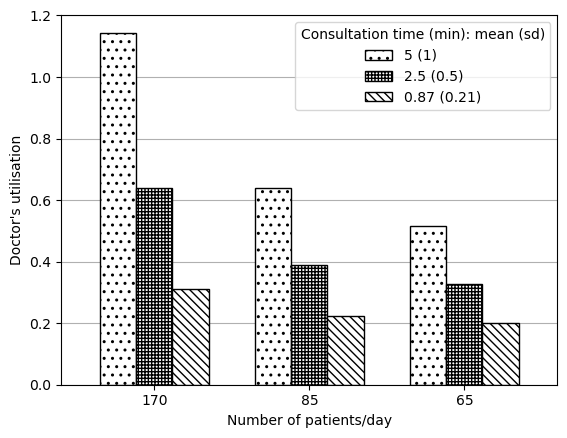

In [10]:
create_2a_2d(data_2a, ylab='''Doctor's utilisation''', file=fig2a_path)

## Create Figure 2B

Import and process data - note: used 0.87 since that is PHC1 and this is described as variants on that but, as paper notes and as I've observed (not shown here), "the doctor's consultation time does not impact this outcome", so it ultimately doesn't matter which is chosen.

In [11]:
# Import and process results
data_2b = process_results([
    'f2_arr170_serv087', 'f2_arr85_serv087', 'f2_arr65_serv087'])

# Rename columns
data_2b.columns = (
    data_2b.columns.str.removeprefix('f2_arr').str.removesuffix('_serv087'))

# Preview data
data_2b.head()

,170,85,65
OPD patients,44055.900000,22092.100000,16668.700000
IPD patients,184.100000,186.500000,174.900000
ANC patients,373.500000,364.400000,362.800000
Del patients,360.600000,372.600000,357.400000
OPD Q wt,0.012007,0.007196,0.003558


Produce figure

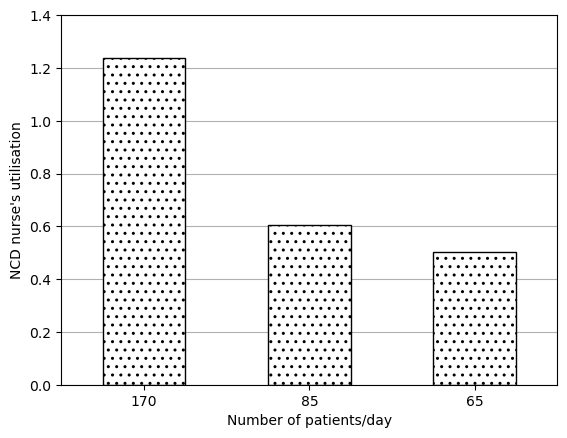

In [12]:
ax = data_2b.loc['NCD occ'].plot.bar(
    edgecolor='black', color='white', hatch='..')
plt.xlabel('Number of patients/day')
plt.ylabel('''NCD nurse's utilisation''')
plt.ylim(0, 1.4)
plt.xticks(rotation=0)
ax.grid(axis='y')
ax.set_axisbelow(True)
plt.savefig(fig2b_path, bbox_inches='tight')
plt.show()

## Create Figure 2C

Import and process data

In [13]:
# Import and process results
data_2c = process_results([
    'f2_arr170_serv5', 'f2_arr85_serv5', 'f2_arr65_serv5'])

# Rename columns
data_2c.columns = (
    data_2c.columns.str.removeprefix('f2_arr').str.removesuffix('_serv5'))

# Preview data
data_2c.head()

,170,85,65
OPD patients,44034.900000,22059.100000,16683.900000
IPD patients,180.500000,180.700000,181.400000
ANC patients,369.800000,370.700000,366.500000
Del patients,371.100000,362.000000,362.700000
OPD Q wt,6.953913,0.536441,0.282745


Produce figure

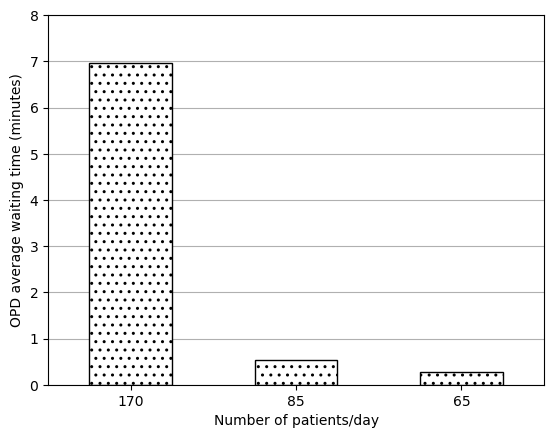

In [14]:
# Create figure
ax = data_2c.loc['OPD Q wt'].plot.bar(
    edgecolor='black', color='white', hatch='..')
plt.xlabel('Number of patients/day')
plt.ylabel('''OPD average waiting time (minutes)''')
plt.xticks(rotation=0)
plt.ylim(0, 8)
ax.grid(axis='y')
ax.set_axisbelow(True)
plt.savefig(fig2c_path, bbox_inches='tight')
plt.show()

## Create Figure 2D

In [15]:
# Filter to pharmacy waiting time
data_2d = data_full.loc['Pharmacy Q wt']
data_2d

f2_arr170_serv087    2.476096
f2_arr85_serv087     0.459063
f2_arr65_serv087     0.292411
f2_arr170_serv25     2.448591
f2_arr85_serv25      0.453829
f2_arr65_serv25      0.284289
f2_arr170_serv5      1.286610
f2_arr85_serv5       0.338799
f2_arr65_serv5       0.215271
Name: Pharmacy Q wt, dtype: float64

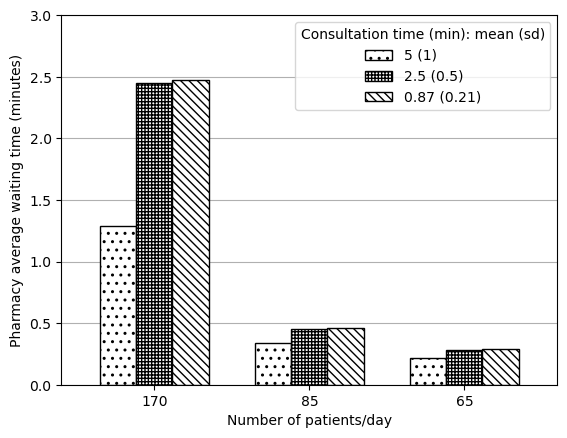

In [16]:
create_2a_2d(data_2d, ylab='Pharmacy average waiting time (minutes)',
             ylim=[0, 3], file=fig2d_path)

## Run time

In [17]:
'''
# Find run time in seconds
end = time.time()
runtime = round(end-start)

# Display converted to minutes and seconds
print(f'Notebook run time: {runtime//60}m {runtime%60}s')
'''

"\n# Find run time in seconds\nend = time.time()\nruntime = round(end-start)\n\n# Display converted to minutes and seconds\nprint(f'Notebook run time: {runtime//60}m {runtime%60}s')\n"